# Set up


In [2]:
%pip install yellowbrick
%pip install numpy
%pip install pandas
%pip install scikit-learn
%pip install seaborn
%pip install pickle


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement pickle (from versions: none)
ERROR: No matching distribution found for pickle


In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_auc_score
from yellowbrick.classifier import ROCAUC
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns

import pickle
import gzip

In [4]:
def checkdf(df):
    print("All url:", len(df))
    if 'label' in df.columns:
        print("Legal url :", len(df[df['label'] == 0]))
        print("Phish url :", len(df[df['label'] == 1]))

In [5]:
df = pd.read_csv('extracted_data.csv')
df.tail()

,url,domainlength,www,subdomain,https,http,short_url,ip,@,-,...,pcextlinks,pcrequrl,zerolink,extfavicon,submit2email,sfh,redirection,domainage,domainend,label
69995,theblondeabroad.com,23,0,0,0,0,0,0,0,0,...,2.657807,1.507538,0,0,0,0,1,1,1,0
69996,internetevolution.com,21,1,0,0,0,0,0,0,0,...,0.000000,0.000000,1,0,0,0,0,1,1,0
69997,holysmoke.org,13,1,0,1,0,0,0,0,0,...,-1.000000,-1.000000,-1,-1,-1,-1,-1,0,0,0
69998,smart.com,16,1,0,0,0,1,0,0,0,...,0.000000,0.000000,1,0,0,0,0,0,0,0
69999,fulltextarchive.com,23,0,0,0,0,0,0,0,0,...,1.851852,0.000000,0,0,0,0,1,0,0,0


In [6]:
checkdf(df)

All url: 70000
Legal url : 35000
Phish url : 35000


# Model


In [7]:
X = df.drop(['label', 'url'], axis=1)
y = np.array(df['label'])

In [8]:
features_selected_ver3 = ['domainlength', 'www', 'https', 'short_url', 'ip', '-', '=', '.', '/', '_', 'digit', 'pcemptylinks', 'pcextlinks', 'pcrequrl', 'zerolink',
                          'extfavicon', 'sfh', 'redirection', 'domainend']

features_selected = features_selected_ver3
print('Number of features selected :', len(features_selected))
print()
print(features_selected)

Number of features selected : 19

['domainlength', 'www', 'https', 'short_url', 'ip', '-', '=', '.', '/', '_', 'digit', 'pcemptylinks', 'pcextlinks', 'pcrequrl', 'zerolink', 'extfavicon', 'sfh', 'redirection', 'domainend']


In [9]:
X_selected = X[features_selected]

In [10]:
# (X_selected == -1).sum()/len(X_selected)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    X_selected, y, test_size=0.30, shuffle=True, stratify=y)
print("Data Shape: ")
print("---- Shape of training data (70%) -----")
print(X_train.shape)
print(y_train.shape)
print("---- Shape of testing data (30%) -----")
print(X_test.shape)
print(y_test.shape)

Data Shape: 
---- Shape of training data (70%) -----
(49000, 19)
(49000,)
---- Shape of testing data (30%) -----
(21000, 19)
(21000,)


In [12]:
model = RandomForestClassifier(n_estimators=300, random_state=0)
model.fit(X_train, y_train)

RandomForestClassifier(n_estimators=300, random_state=0)

---- METRICS RESULTS FOR TESTING DATA ----

Test Model Accuracy is :  0.9592380952380952

Classification Report: 
               precision    recall  f1-score   support

           0       0.96      0.96      0.96     10500
           1       0.96      0.96      0.96     10500

    accuracy                           0.96     21000
   macro avg       0.96      0.96      0.96     21000
weighted avg       0.96      0.96      0.96     21000



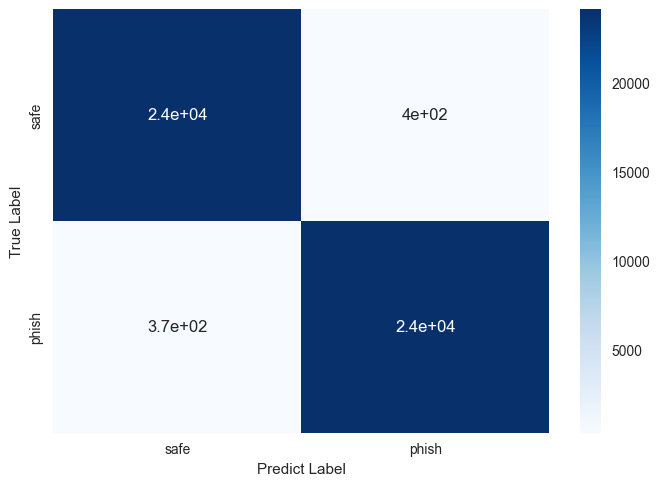

In [13]:
# Prediction
y_pred_test = model.predict(X_test)
y_pred_train = model.predict(X_train)
test_acc = accuracy_score(y_test, y_pred_test)
test_rep = classification_report(y_test, y_pred_test)

print("---- METRICS RESULTS FOR TESTING DATA ----")
print()
print("Test Model Accuracy is : ", test_acc)
print()
print("Classification Report: \n", test_rep)

cf = confusion_matrix(y_train, y_pred_train)
sns.heatmap(cf, annot=True, cmap='Blues', yticklabels=[
            'safe', 'phish'], xticklabels=['safe', 'phish'])
plt.ylabel("True Label")
plt.xlabel("Predict Label")
plt.show()

c:\Python311\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


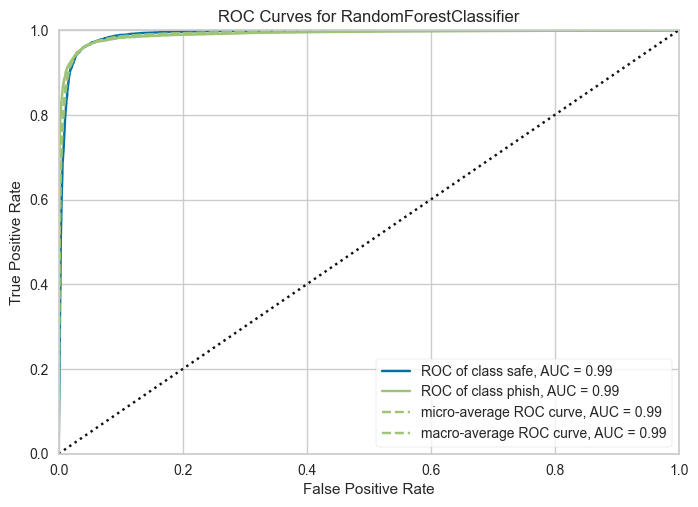

<Axes: title={'center': 'ROC Curves for RandomForestClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [14]:
from yellowbrick.classifier import ROCAUC
visualizer = ROCAUC(model, classes=['safe', 'phish'])
# Fit the training data to the visualizer
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)        # Evaluate the model on the test data
visualizer.show()

In [15]:
roc_auc_score(y_train, model.predict_proba(X_train)[:, 1])

0.9988409537692629

In [16]:
roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])

0.9902697641723356

In [17]:
roc_auc_score(y, model.predict_proba(X_selected)[:, 1])

0.9966412310204082

In [18]:
feature_importance_map = {}
importances = model.feature_importances_
for feature, importance in zip(features_selected, importances):
    feature_importance_map[feature] = (importance*100).round(2)

sorted_dict = {k: v for k, v in sorted(
    feature_importance_map.items(), key=lambda item: item[1], reverse=True)}
sorted_dict

{'pcextlinks': 15.51,
 'domainlength': 13.96,
 '-': 11.39,
 '/': 9.01,
 'www': 7.8,
 'https': 6.67,
 'pcemptylinks': 6.51,
 'digit': 5.17,
 'pcrequrl': 4.5,
 'redirection': 4.42,
 'domainend': 3.53,
 'zerolink': 3.5,
 '.': 2.89,
 'extfavicon': 1.52,
 'sfh': 1.44,
 '=': 1.36,
 'short_url': 0.46,
 '_': 0.32,
 'ip': 0.02}

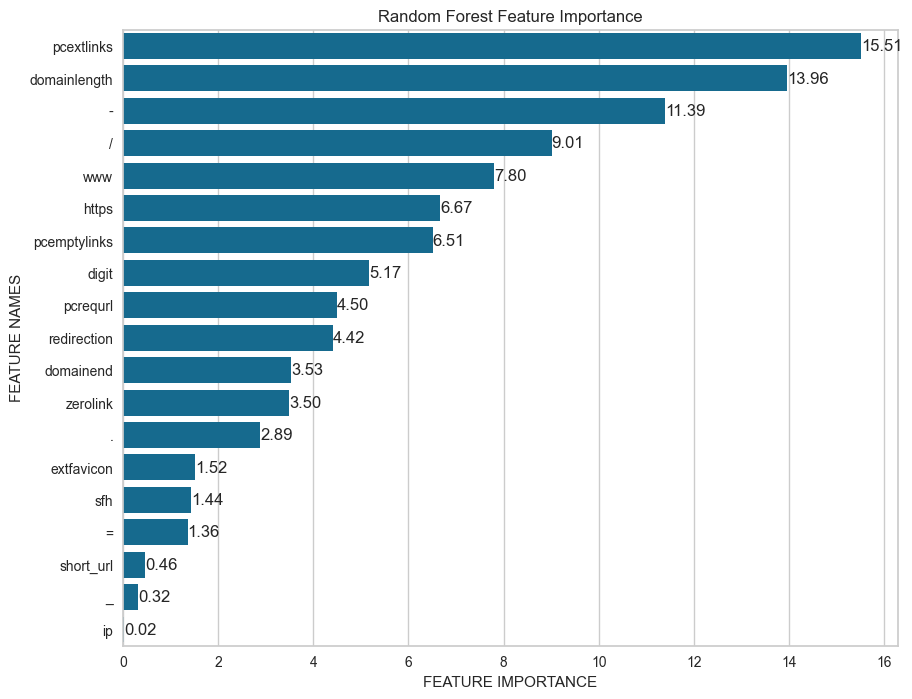

In [19]:
data = {'feature_names': features_selected, 'feature_importance': (
    model.feature_importances_*100).round(2)}
fi_df = pd.DataFrame(data)
fi_df.sort_values(by=['feature_importance'], ascending=False, inplace=True)

# Define size of bar plot
plt.figure(figsize=(10, 8))
# Plot Searborn bar chart
barplot = sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
# Add chart labels
plt.title('Random Forest Feature Importance')
plt.xlabel('FEATURE IMPORTANCE')
plt.ylabel('FEATURE NAMES')
for bar in barplot.patches:
    # Get the x and y coordinates of the bar
    x = bar.get_x() + bar.get_width()
    y = bar.get_y() + bar.get_height() / 2

    # Add the text annotation to the bar
    barplot.text(x, y, f'{bar.get_width():.2f}', ha='left', va='center')

In [20]:
# gzip
# def save_zipped_pickle(obj, filename, protocol=-1):
#     with gzip.open(filename, 'wb') as f:
#         pickle.dump(obj, f, protocol)

In [21]:
%pip install joblib

Note: you may need to restart the kernel to use updated packages.


In [22]:
import joblib

joblib.dump(model, "model.joblib")

['model.joblib']

In [23]:
# save_zipped_pickle(model, "model_compressed_ver3.gzip", protocol=-1)